In [1]:
import os
import time
import copy
from pathlib import Path
import itertools
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, log_loss, brier_score_loss

from utils_data import split_dataset
from utils_metrics import brier_loss, plot_confusion_matrix, plot_precision_recall_curve, evaluate_model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Example usage
if not Path("skin_cancer_dataset/train").exists():
    split_dataset("skin_cancer_dataset", train_ratio=0.7, val_ratio=0.2, image_ext="*.jpg")

In [4]:
data_dir = 'skin_cancer_dataset'

# Data augmentation for train; only normalization for val & calibration
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'calibration': transforms.Compose([  # Same as val, no augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets including calibration
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'calibration']}

# Create dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == 'train' else False, num_workers=4)
              for x in ['train', 'val', 'calibration']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'calibration']}

# Class names
class_names = image_datasets['train'].classes
class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [5]:
model = models.vgg16(pretrained=True)

# Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False  

# Train classifier
for param in model.classifier.parameters():
    param.requires_grad = True  

# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 7)  
# model.classifier[3] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 2)


model = model.to(device)
# model

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [43]:
criterion = nn.CrossEntropyLoss()

# LAYERS = model.classifier[6]
LAYERS = model.classifier
LEARNING_RATE = 0.0001

# Only parameters of the final layer are being optimized
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(LAYERS.parameters(), lr=LEARNING_RATE)

# LAYERS

In [21]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0  # Track best F1-score

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterate over data with tqdm progress bar
            iterate_dataloader = tqdm(dataloaders[phase], desc=f"{phase.upper()} Epoch {epoch+1}/{num_epochs}")

            for inputs, labels in iterate_dataloader:
            # for inputs, labels in itertools.islice(iterate_dataloader, 5):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get class with highest probability
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Store labels and predictions for F1-score computation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Compute Macro F1-score (equal weight for all classes)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Save model if it has the best F1-score
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1: {best_f1:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [44]:
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5) # num_epochs=25 

Epoch 1/5
----------


TRAIN Epoch 1/5: 100%|██████████| 220/220 [00:45<00:00,  4.87it/s]


train Loss: 0.5580 Acc: 0.8046 F1: 0.5947


VAL Epoch 1/5: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


val Loss: 0.6569 Acc: 0.7918 F1: 0.5819

Epoch 2/5
----------


TRAIN Epoch 2/5: 100%|██████████| 220/220 [00:45<00:00,  4.84it/s]


train Loss: 0.5467 Acc: 0.8017 F1: 0.6011


VAL Epoch 2/5: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


val Loss: 0.6602 Acc: 0.7878 F1: 0.5615

Epoch 3/5
----------


TRAIN Epoch 3/5: 100%|██████████| 220/220 [00:45<00:00,  4.83it/s]


train Loss: 0.5421 Acc: 0.8098 F1: 0.6216


VAL Epoch 3/5: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]


val Loss: 0.6647 Acc: 0.7888 F1: 0.5960

Epoch 4/5
----------


TRAIN Epoch 4/5: 100%|██████████| 220/220 [00:45<00:00,  4.82it/s]


train Loss: 0.5596 Acc: 0.8053 F1: 0.5824


VAL Epoch 4/5: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


val Loss: 0.6316 Acc: 0.7943 F1: 0.5839

Epoch 5/5
----------


TRAIN Epoch 5/5: 100%|██████████| 220/220 [00:45<00:00,  4.83it/s]


train Loss: 0.5132 Acc: 0.8181 F1: 0.6420


VAL Epoch 5/5: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]

val Loss: 0.6361 Acc: 0.8023 F1: 0.5961

Training complete in 4m 44s
Best val F1: 0.5961


In [11]:
# for x,_ in dataloaders["val"]:
#     print(model(x))
#     break

In [45]:
# torch.save(model, "model_F1_6120.pth")

model = torch.load("model_F1_6120.pth")
model.eval() 

/tmp/ipykernel_3757/369852154.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_F1_6120.pth")


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
import torch
import torch.nn.functional as F

def predict_proba(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in tqdm(dataloader):
        # for inputs, labels in tqdm(itertools.islice(dataloader, 5)):
            inputs = inputs.to(device)  # Move input to GPU/CPU
            outputs = model(inputs)  # Get raw model outputs (logits)

            # Apply Softmax to get probabilities for all classes
            probs = F.softmax(outputs, dim=1)  # Keep all class probabilities

            all_probs.append(probs.cpu())  # Move to CPU and store
            all_labels.append(labels.cpu())

    return torch.cat(all_labels), torch.cat(all_probs)  # Concatenate all probabilities into a single tensor

# Run inference on validation dataset
val_labels, val_probs = predict_proba(model, dataloaders['val'], device)
cal_labels, cal_probs = predict_proba(model, dataloaders['calibration'], device)

# Print shape of output tensor
print("Validation Probabilities Shape:", val_probs.shape)  # Should match (num_samples, num_classes)
print("Validation Labels:")
print(val_labels)
print("Validation Probabilities:")
print(val_probs)  # Display tensor of probabilities


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]

Validation Probabilities Shape: torch.Size([2003, 7])
Validation Labels:
tensor([0, 0, 0,  ..., 6, 6, 6])
Validation Probabilities:
tensor([[6.6555e-01, 1.5377e-01, 2.3847e-02,  ..., 1.5171e-01, 5.0989e-03,
         5.3623e-06],
        [4.3710e-01, 2.0065e-01, 7.2741e-02,  ..., 2.5128e-01, 2.9637e-02,
         1.2477e-05],
        [6.6586e-03, 9.4603e-03, 3.6210e-01,  ..., 1.9059e-02, 5.7240e-01,
         9.8795e-04],
        ...,
        [1.9370e-07, 2.8653e-02, 2.7936e-04,  ..., 1.7337e-03, 5.5051e-04,
         9.6878e-01],
        [3.7842e-10, 7.7051e-06, 7.5573e-04,  ..., 4.9030e-07, 4.1403e-06,
         9.9923e-01],
        [4.7878e-05, 4.9651e-03, 4.8625e-03,  ..., 9.1982e-04, 3.9655e-03,
         9.8524e-01]])


# Base Model Evaluation
Accuracy: 0.8002995506739891
F1 Score (macro): 0.6120178463964121
F1 Score (weighted): 0.7899011369321289

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.49      0.54      0.52        74
         BCC       0.61      0.60      0.60       104
         BKL       0.65      0.56      0.60       236
          DF       0.86      0.21      0.34        28
         MEL       0.63      0.46      0.53       218
          NV       0.87      0.94      0.91      1315
        VASC       0.87      0.71      0.78        28

    accuracy                           0.80      2003
   macro avg       0.71      0.58      0.61      2003
weighted avg       0.79      0.80      0.79      2003



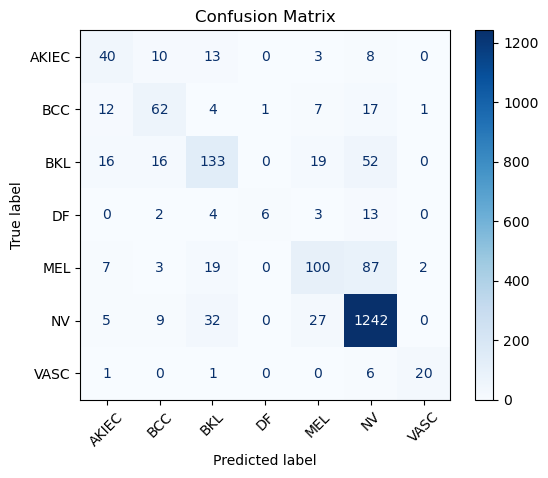


# Precision-Recall Curves


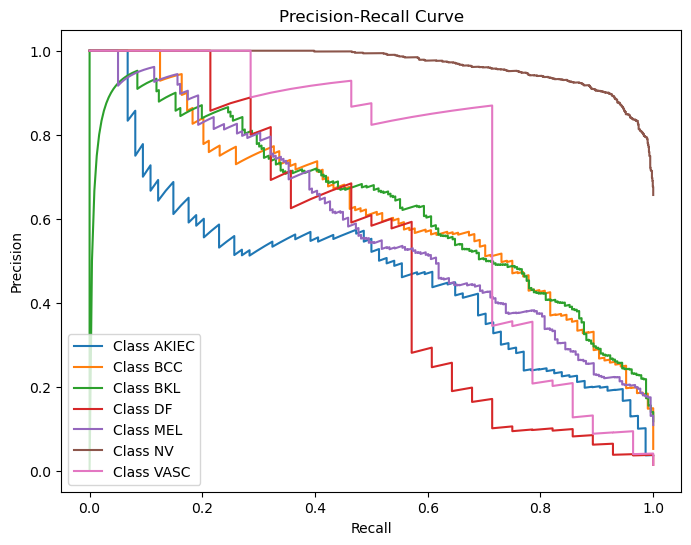

Average Precision Score (macro): 0.6492813610795279

# Calibration Evaluation
Log Loss: 0.6003557731050855
Brier Score Loss (macro): 0.04197229238786811


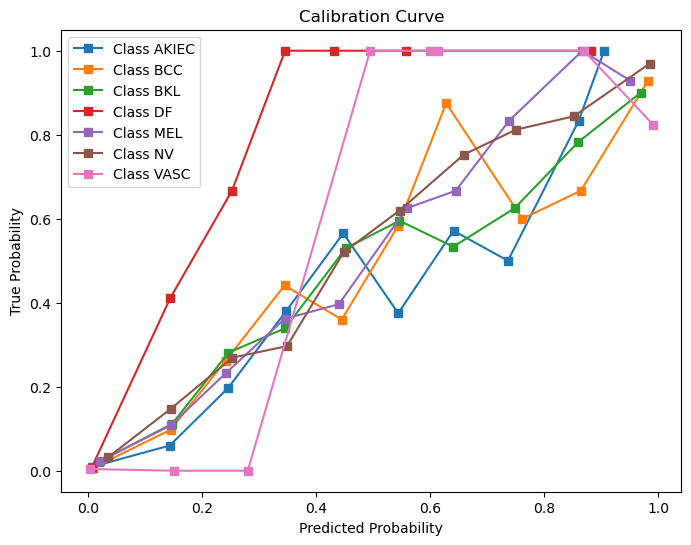

In [49]:
evaluate_model(val_labels, val_probs, class_names=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [50]:
# # Fit logistic regression for Platt Scaling
# platt_scaler = LogisticRegression()
# platt_scaler.fit(cal_probs.reshape(-1, 1), cal_labels)

# # Get calibrated probabilities
# platt_probs = platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1]

In [57]:
cal_probs = cal_probs.cpu().numpy() if isinstance(cal_probs, torch.Tensor) else np.array(cal_probs)
val_probs = val_probs.cpu().numpy() if isinstance(val_probs, torch.Tensor) else np.array(val_probs)
cal_labels = cal_labels.cpu().numpy() if isinstance(cal_labels, torch.Tensor) else np.array(cal_labels)

num_classes = cal_probs.shape[1]
calibrated_probs = np.zeros_like(val_probs)

for i in range(num_classes):

    # Fit Logistic Regression for Platt Scaling
    platt_scaler = LogisticRegression()
    platt_scaler.fit(cal_probs, (cal_labels == i).astype(int))  # Fit binary for class i

    # Get calibrated probabilities
    calibrated_probs[:, i] = platt_scaler.predict_proba(val_probs)[:, 1]  # Keep probability for class i

# Normalize calibrated probabilities to ensure they sum to 1
platt_probs = calibrated_probs / calibrated_probs.sum(axis=1, keepdims=True)

# Base Model Evaluation
Accuracy: 0.7863205192211683
F1 Score (macro): 0.5285969038120947
F1 Score (weighted): 0.7674163995414761

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.54      0.43      0.48        74
         BCC       0.61      0.47      0.53       104
         BKL       0.63      0.51      0.56       236
          DF       0.00      0.00      0.00        28
         MEL       0.59      0.46      0.52       218
          NV       0.85      0.96      0.90      1315
        VASC       0.85      0.61      0.71        28

    accuracy                           0.79      2003
   macro avg       0.58      0.49      0.53      2003
weighted avg       0.76      0.79      0.77      2003



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


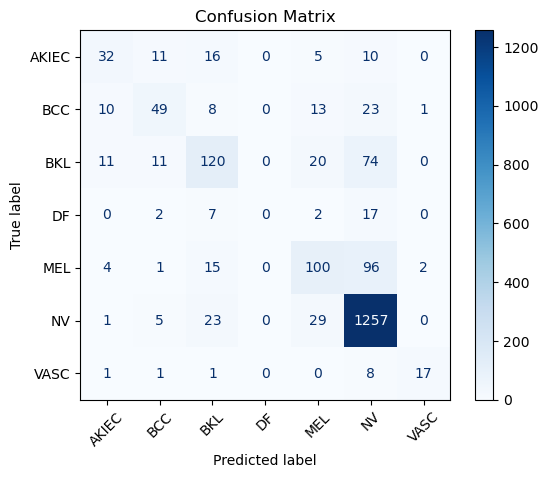


# Precision-Recall Curves


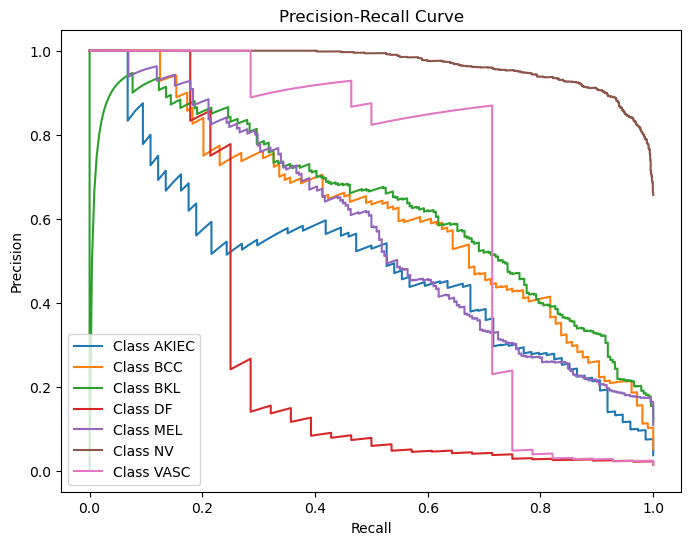

Average Precision Score (macro): 0.6069701199826382

# Calibration Evaluation
Log Loss: 0.6613344211428687
Brier Score Loss (macro): 0.043818465365032574


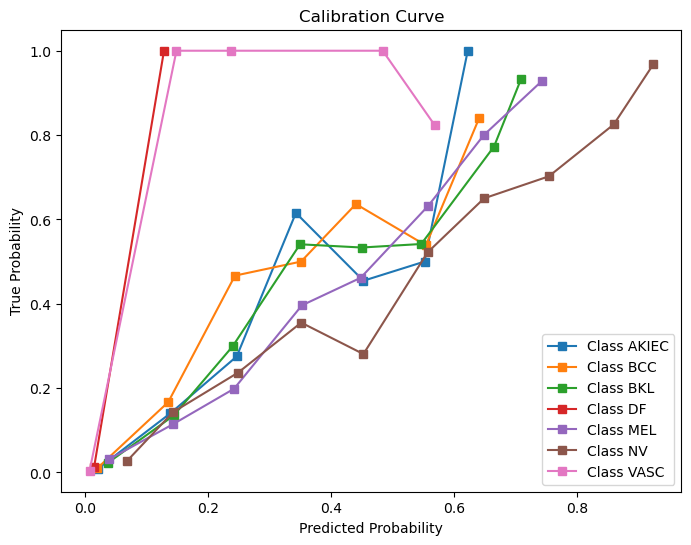

In [58]:
evaluate_model(val_labels, platt_probs, class_names=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [59]:
# # Fit isotonic regression
# iso_reg = IsotonicRegression(out_of_bounds="clip")  # Clip ensures values remain in valid probability range
# iso_reg.fit(cal_probs, cal_labels)

# # Get calibrated probabilities
# iso_probs = iso_reg.predict(val_probs)

In [61]:
# Initialize storage
iso_probs = np.zeros_like(val_probs)

# Apply Isotonic Regression (One-vs-Rest) for each class
for i in range(num_classes):
    # Extract per-class probabilities (Isotonic Regression requires 1D input)
    cal_probs_class = cal_probs[:, i]  # 1D array
    val_probs_class = val_probs[:, i]  # 1D array

    # Fit Isotonic Regression (One-vs-Rest)
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(cal_probs_class, (cal_labels == i).astype(int))  # Fit per class

    # Get calibrated probabilities
    iso_probs[:, i] = iso_reg.predict(val_probs_class)  # Ensure per-class predictions

# Normalize calibrated probabilities to ensure they sum to 1
iso_probs = iso_probs / iso_probs.sum(axis=1, keepdims=True)

# Print shape to verify
print("Isotonic Calibrated Probabilities Shape:", iso_probs.shape)

Isotonic Calibrated Probabilities Shape: (2003, 7)


# Base Model Evaluation
Accuracy: 0.7943085371942087
F1 Score (macro): 0.6015692019532752
F1 Score (weighted): 0.7863410750457759

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.41      0.39      0.40        74
         BCC       0.60      0.61      0.60       104
         BKL       0.64      0.61      0.63       236
          DF       0.64      0.32      0.43        28
         MEL       0.58      0.45      0.51       218
          NV       0.88      0.93      0.91      1315
        VASC       0.86      0.64      0.73        28

    accuracy                           0.79      2003
   macro avg       0.66      0.57      0.60      2003
weighted avg       0.78      0.79      0.79      2003



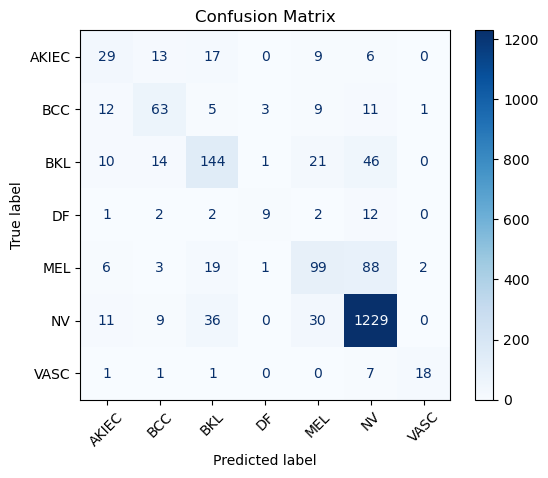


# Precision-Recall Curves


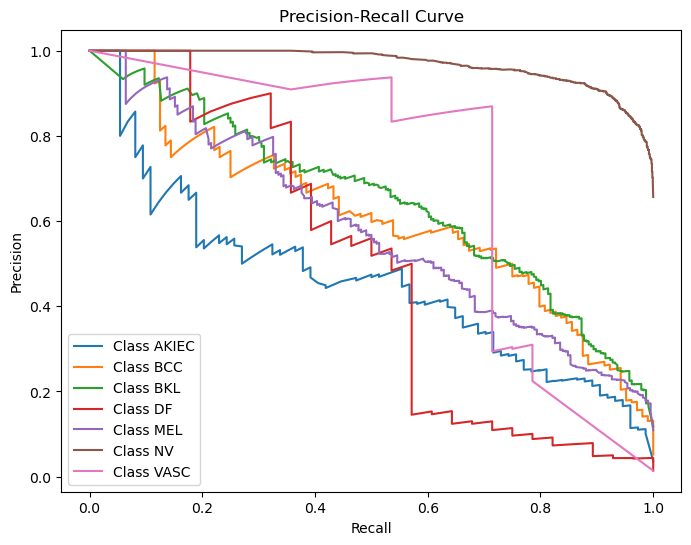

Average Precision Score (macro): 0.6334223302020531

# Calibration Evaluation
Log Loss: 0.650910157628312
Brier Score Loss (macro): 0.04218952340117847


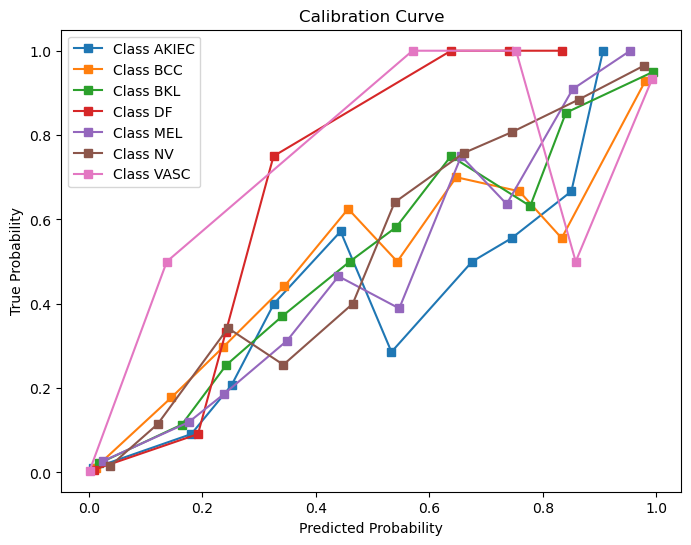

In [63]:
evaluate_model(val_labels, iso_probs, class_names=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])